In [1]:
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload complete

In [2]:
from math import ceil
from functools import partial
from pathlib import Path
import datetime

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import dask
import cftime

from project.io import IntakeESMLoader, save_mfdataset
from project.plotting import plot_field
from project.util import stack_state, unstack_state, is_dask_array, get_data_path
from project.eof import EOF, EOFXArray, EOFMethod
from project.spaces import PhysicalSpaceForecastSpaceMapper, Detrend, NanMask

In [3]:
ds = xr.open_dataset("/home/enkf6/dstiller/test_io_output.nc", chunks=dict(time=1))[
    ["ohc700", "tas", "psl", "pr"]
]

In [4]:
ds

<xarray.Dataset>
Dimensions:  (time: 480, lat: 90, lon: 180)
Coordinates:
  * time     (time) object 7001-01-16 12:00:00 ... 7040-12-16 12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    ohc700   (time, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    tas      (time, lat, lon) float32 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    psl      (time, lat, lon) float32 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>

In [5]:
data = ds["psl"].isel(time=slice(None, 100)).dropna("lat")
data = stack_state(data)
data -= data.mean(dim="time")
data

<xarray.DataArray '' (state: 15840, time: 100)>
dask.array<sub, shape=(15840, 100), dtype=float32, chunksize=(15840, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 7001-01-16 12:00:00 ... 7009-04-16 00:00:00
  * state    (state) object MultiIndex
  * field    (state) object 'psl' 'psl' 'psl' 'psl' ... 'psl' 'psl' 'psl' 'psl'
  * lon      (state) float64 0.0 0.0 0.0 0.0 0.0 ... 358.0 358.0 358.0 358.0
  * lat      (state) float64 -87.0 -85.0 -83.0 -81.0 ... 81.0 83.0 85.0 87.0
Attributes:
    standard_name:  air_pressure_at_mean_sea_level
    long_name:      Sea Level Pressure
    units:          Pa
    realm:          atmos
    regrid_method:  bilinear

In [6]:
eof = EOFXArray(10)
eof.fit(data)

2023-12-06 20:45:53   DEBUG Calculating EOFs using Dask (rank = 10)


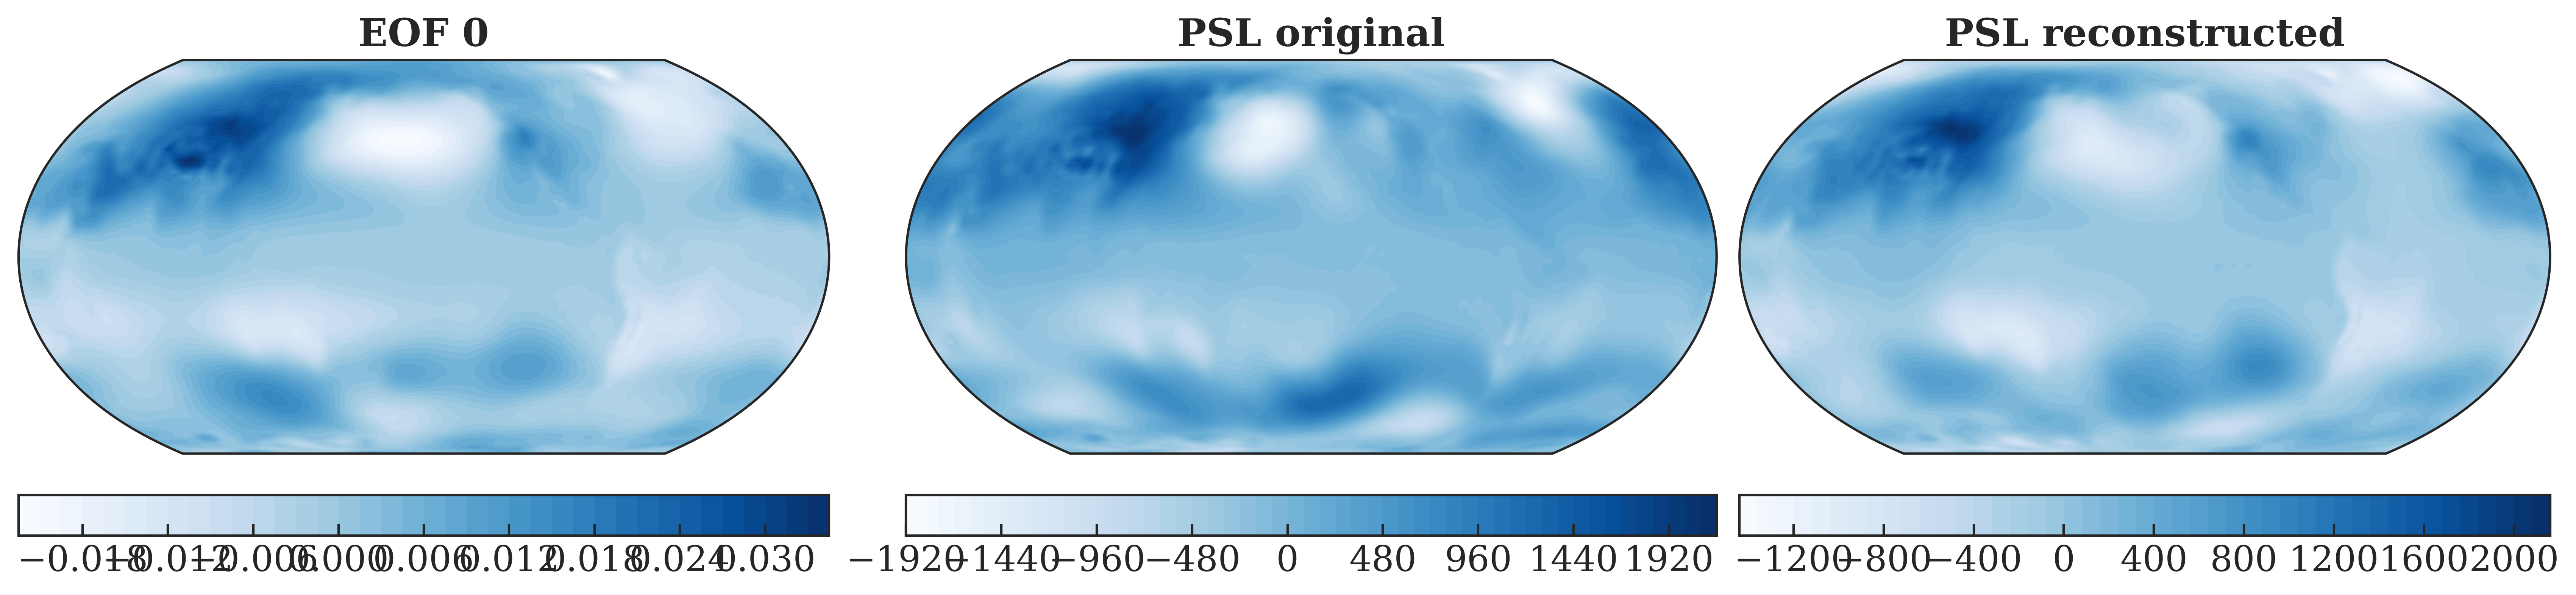

In [7]:
fig, axs = plt.subplots(
    1,
    3,
    figsize=(15, 5),
    subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=198)),
)

axs[0].set_title("EOF 0")
plot_field(axs[0], unstack_state(eof.get_component(0))["psl"].T)

axs[1].set_title("PSL original")
plot_field(axs[1], unstack_state(data.isel(time=0))["psl"].T)

axs[2].set_title("PSL reconstructed")
plot_field(
    axs[2],
    unstack_state(eof.project_backwards(eof.project_forwards(data.isel(time=0))))[
        "psl"
    ].T,
)

In [8]:
data = ds.isel(time=slice(None, 50))

mapper = PhysicalSpaceForecastSpaceMapper(10, 30, 20, ["ohc700"], ["pr"])
mapper.fit(data)

2023-12-06 20:46:11    INFO PhysicalSpaceForecastSpaceMapper.fit()
2023-12-06 20:46:11    INFO Splitting dataset into Dask arrays
2023-12-06 20:46:11    INFO Masking nans


2023-12-06 20:46:12    INFO Calculating field variances
2023-12-06 20:46:13    INFO Detrending data
2023-12-06 20:46:14    INFO Standardizing pr before individual EOF
2023-12-06 20:46:14    INFO Fitting EOF for ohc700 [1/4]
2023-12-06 20:46:14   DEBUG Calculating EOFs using Dask (rank = 20)
2023-12-06 20:46:15    INFO Projecting EOF for ohc700
2023-12-06 20:46:15    INFO Standardizing ohc700 after individual EOF
2023-12-06 20:46:15    INFO Fitting EOF for tas [2/4]
2023-12-06 20:46:15   DEBUG Calculating EOFs using Dask (rank = 10)
2023-12-06 20:46:16    INFO Projecting EOF for tas
2023-12-06 20:46:16    INFO Standardizing tas after individual EOF
2023-12-06 20:46:16    INFO Fitting EOF for psl [3/4]
2023-12-06 20:46:16   DEBUG Calculating EOFs using Dask (rank = 10)
2023-12-06 20:46:17    INFO Projecting EOF for psl
2023-12-06 20:46:17    INFO Standardizing psl after individual EOF
2023-12-06 20:46:17    INFO Fitting EOF for pr [4/4]
2023-12-06 20:46:17   DEBUG Calculating EOFs using 

In [9]:
# mapper.save(Path("/home/enkf6/dstiller/enspred/mapper"))

In [10]:
x = mapper.forward(data)
x

2023-12-06 20:46:19    INFO PhysicalSpaceForecastSpaceMapper.forward()
2023-12-06 20:46:19    INFO Splitting dataset into Dask arrays
2023-12-06 20:46:19    INFO Masking nans


2023-12-06 20:46:19    INFO Detrending data
2023-12-06 20:46:19    INFO Standardizing pr before individual EOF
2023-12-06 20:46:19    INFO Projecting EOF for ohc700 [1/4]
2023-12-06 20:46:19    INFO Standardizing ohc700 after individual EOF
2023-12-06 20:46:19    INFO Projecting EOF for tas [2/4]
2023-12-06 20:46:19    INFO Standardizing tas after individual EOF
2023-12-06 20:46:19    INFO Projecting EOF for psl [3/4]
2023-12-06 20:46:19    INFO Standardizing psl after individual EOF
2023-12-06 20:46:19    INFO Projecting EOF for pr [4/4]
2023-12-06 20:46:19    INFO Projecting joint EOF for psl, tas, pr
2023-12-06 20:46:19    INFO Appending direct fields for ohc700


dask.array<concatenate, shape=(50, 50), dtype=float64, chunksize=(30, 1), chunktype=numpy.ndarray>

In [11]:
y = mapper.backward(x, data.time)
y

2023-12-06 20:46:19    INFO PhysicalSpaceForecastSpaceMapper.backward()
2023-12-06 20:46:19    INFO Splitting direct fields for ohc700
2023-12-06 20:46:19    INFO Back-projecting joint EOF for psl, tas, pr
2023-12-06 20:46:19    INFO De-standardizing ohc700 after individual EOF
2023-12-06 20:46:19    INFO Back-projecting EOF for ohc700 [1/4]
2023-12-06 20:46:19    INFO De-standardizing tas after individual EOF
2023-12-06 20:46:19    INFO Back-projecting EOF for tas [2/4]
2023-12-06 20:46:19    INFO De-standardizing psl after individual EOF
2023-12-06 20:46:19    INFO Back-projecting EOF for psl [3/4]
2023-12-06 20:46:19    INFO Back-projecting EOF for pr [4/4]
2023-12-06 20:46:19    INFO Re-trending data
2023-12-06 20:46:19    INFO De-standardizing pr before individual EOF
2023-12-06 20:46:19    INFO Un-masking nans
2023-12-06 20:46:19    INFO Merging Dask arrays into dataset


<xarray.Dataset>
Dimensions:  (lon: 180, lat: 90, time: 50)
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * time     (time) object 7001-01-16 12:00:00 ... 7005-02-15 00:00:00
Data variables:
    ohc700   (time, lat, lon) float64 dask.array<chunksize=(50, 90, 180), meta=np.ndarray>
    tas      (time, lat, lon) float64 dask.array<chunksize=(50, 90, 180), meta=np.ndarray>
    psl      (time, lat, lon) float64 dask.array<chunksize=(50, 90, 180), meta=np.ndarray>
    pr       (time, lat, lon) float64 dask.array<chunksize=(50, 90, 180), meta=np.ndarray>

In [12]:
xr.DataArray(x, coords=dict(state=np.arange(x.shape[0]), time=data.time))

<xarray.DataArray 'concatenate-9bd858a984e5e1ad5c068c0401ab4290' (state: 50,
                                                                  time: 50)>
dask.array<concatenate, shape=(50, 50), dtype=float64, chunksize=(30, 1), chunktype=numpy.ndarray>
Coordinates:
  * state    (state) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) object 7001-01-16 12:00:00 ... 7005-02-15 00:00:00

In [13]:
save_mfdataset(xr.DataArray(x, coords=dict(state=np.arange(x.shape[0]), time=data.time)).to_dataset(name="data"), get_data_path() / "training_data")

2023-12-06 20:46:20    INFO Saving dataset to /home/enkf6/dstiller/enspred/training_data/2023-12-06T20-46-20


In [14]:
((y - data) ** 2).mean().compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    ohc700   float64 2.36e+16
    tas      float64 1.495
    psl      float64 6.167e+04
    pr       float64 1.8e-10

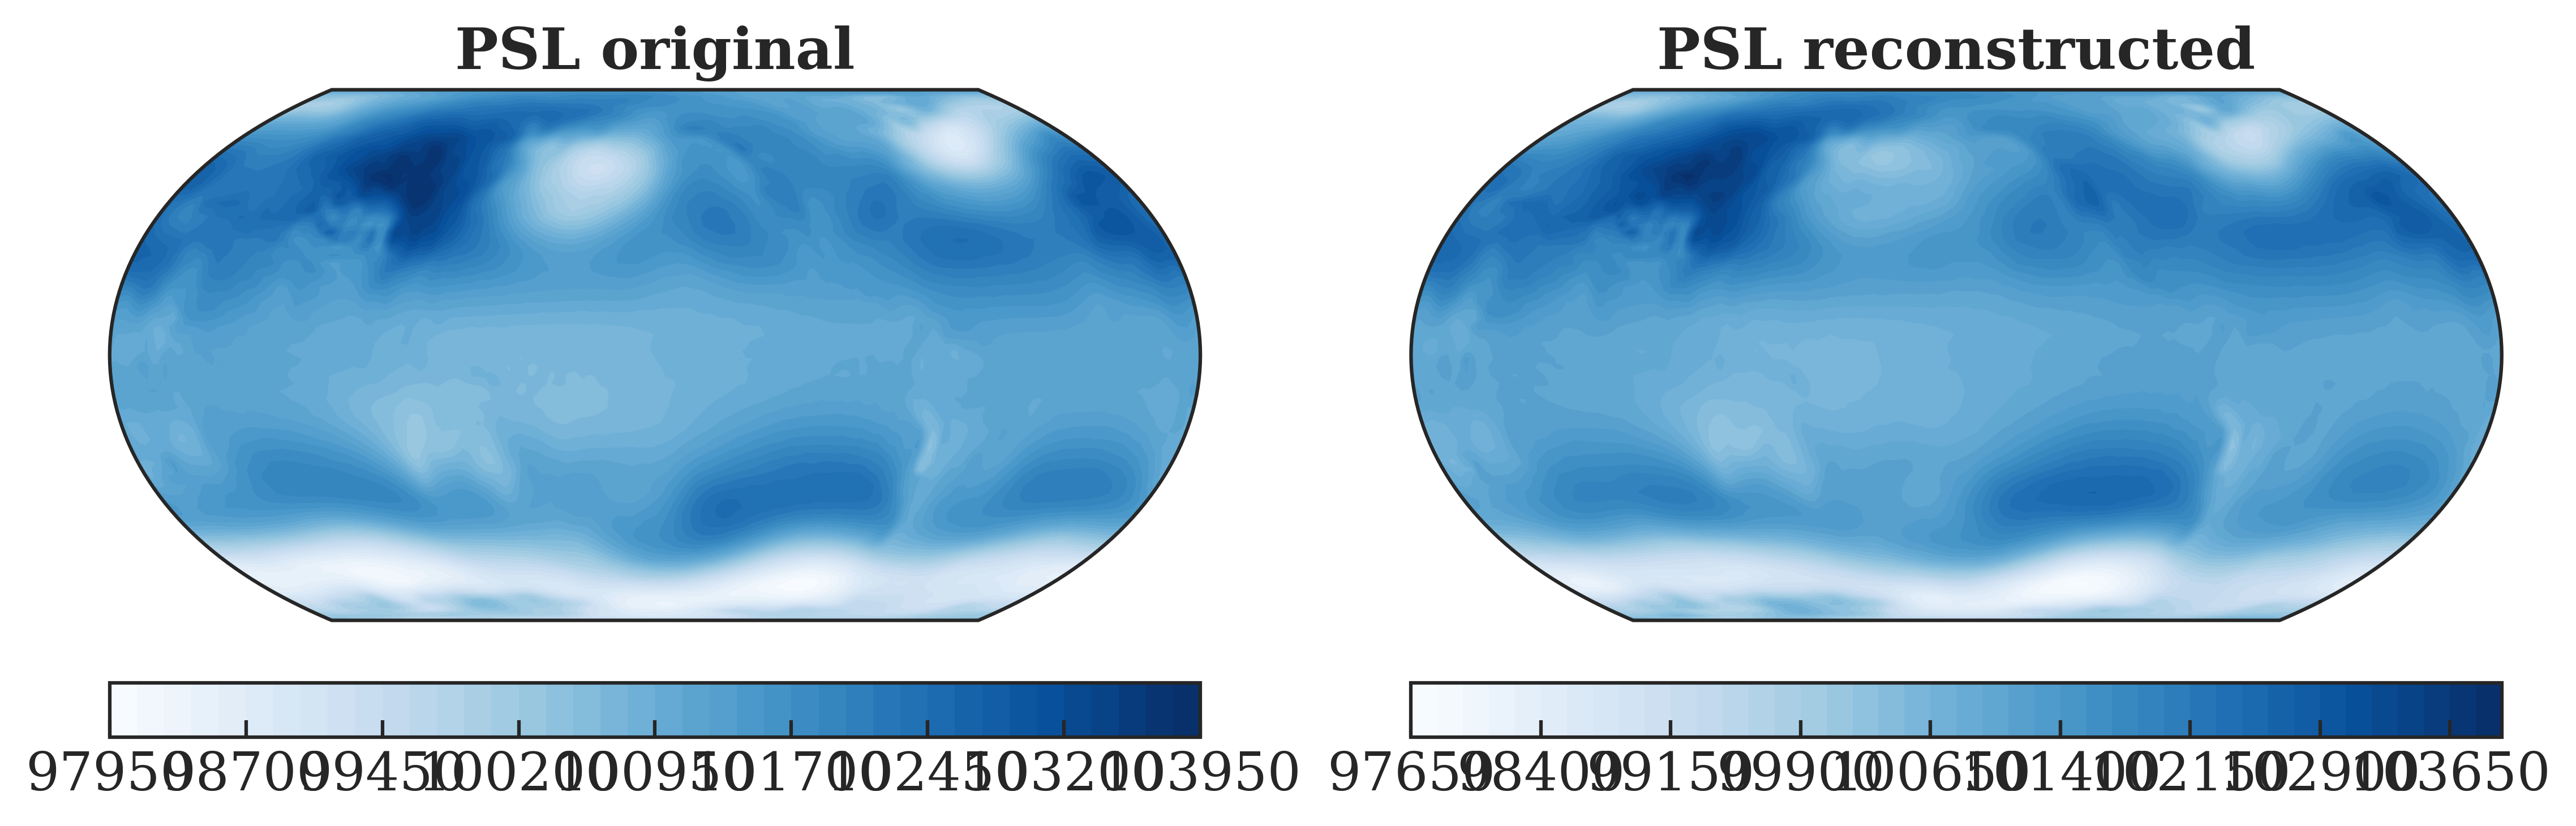

In [15]:
fig, axs = plt.subplots(
    1,
    2,
    figsize=(10, 5),
    subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=198)),
)

axs[0].set_title("PSL original")
plot_field(axs[0], data.isel(time=0)["psl"])

axs[1].set_title("PSL reconstructed")
plot_field(axs[1], y.isel(time=0)["psl"])